In [1]:
import numpy as np # linear algebra
import pandas as pd
import os, types

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model


In [ ]:
model_save_path = os.path.join('../results/model', 'colab')
print(model_save_path)

In [13]:

# model = load_model(model_save_path)
model = load_model('fire.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 64)      51264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dense_4 (Dense)             (None, 512)              

24576/13578 [======================================================] - 0s 1us/step
../data/datasets/test_img


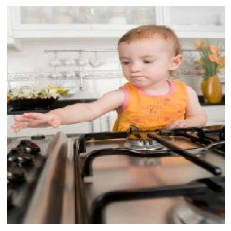

In [14]:
!rm -rf ../data/datasets/test_img
class_names = ['fire', 'non_fire']

# test_img_url = 'https://climate.esa.int/media/images/Fire-CCI-banner_1.2e16d0ba.fill-600x314-c100.format-jpeg.jpg'
# test_img_url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/small-kitchen-1572367025.png'
# test_img_url = 'https://images.indianexpress.com/2021/03/Pune-fire-1.jpg'
# test_img_url = 'https://i.insider.com/56843d15dd0895dc648b47fd?width=1000&format=jpeg&auto=webp'
# test_img_url = 'https://charlestonfire.org/images/public-news/large/news-1501509679.jpg' 
test_img_url = 'https://cf.ltkcdn.net/safety/images/std/116578-232x317r1-Kitchenfireprevention.jpg' # No_Fire
# test_img_url ='https://www.kutchina.com/wp-content/uploads/2020/07/straight-line-2-min-600x350.jpg' # No_Fire
# test_img_url = 'https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/kitchen-ideas-wall-display-1603743563.jpg'
# test_img_url = 'https://media.springernature.com/lw725/springer-cms/rest/v1/content/19831396/data/v1' # False Negative
# test_img_url = 'https://media-exp1.licdn.com/dms/image/C4D1BAQGrF7AoQDBPXQ/company-background_10000/0/1631550860606?e=2147483647&v=beta&t=0MXoiDfXevwDLrZ8ZHFEXxlcS0T_iyMShpgHlunLMQo'
# test_img_url = 'https://www.thespruce.com/thmb/XMuqYgCjvYclSkDrm7ALrwnoXw8=/1777x1333/smart/filters:no_upscale()/fire-pit-backyard-ideas-4177680-hero-4b2d98b9204b4cd4bdb534a5a9b106f4.jpg' # False Negative

test_img_path = tf.keras.utils.get_file('test_img', origin=test_img_url, cache_dir='../data')
# test_img_path = '/Users/gurvindersingh/Downloads/fire.jpeg'

# test_img_path = '../data/fire_dataset/non_fire/10.jpg'

print(test_img_path)

img = keras.preprocessing.image.load_img(
    test_img_path, target_size=(224, 224)
)

plt.imshow(img)
plt.axis('off')
plt.show()

In [15]:
# image = Image.open(test_img_path).convert('RGB').resize(IMAGE_SIZE, Image.ANTIALIAS)
# img_array = np.float32(image) / 255
img_array = keras.preprocessing.image.img_to_array(img) / 255
# img_array = (np.float32(image) - 123) / 123
# img_array = tf.expand_dims(img_array, 0) # Create a batch
# img_array = np.expand_dims(img_array, axis=0)

predictions = model.predict(np.expand_dims(img_array, axis=0))
print("predictions: ", predictions)
score = tf.nn.softmax(predictions[0])
predicted_index = np.argmax(predictions)
score = tf.nn.softmax(predictions[0])

# print('score: ', score)
print('Class: ', np.argmax(score))
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

(1, 224, 224, 3)
predictions:  [[0.97386676 0.02613326]]
Class:  0
This image most likely belongs to fire with a 72.07 percent confidence.


In [17]:
# Load the TFLite model and allocate tensors.

lite_model_path = os.path.join('../results/model', 'fire_detection')

interpreter = tf.lite.Interpreter(model_path=lite_model_path+'/model.tflite')
interpreter.allocate_tensors()

_, height, width, _ = interpreter.get_input_details()[0]['shape']
print('width: ', width, ', height: ', height)
input_index = interpreter.get_input_details()[0]["index"]
output_details = interpreter.get_output_details()[0]
output_index = output_details["index"]


width:  224 , height:  224


In [18]:
def set_input_tensor(interpreter, image):
    tensor_index = interpreter.get_input_details()[0]['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

def classify_image(interpreter, image, top_k=1):
    """Returns a sorted array of classification results."""
#     set_input_tensor(interpreter, image)
    interpreter.set_tensor(input_index, image)
    interpreter.invoke()
    
#     output = np.squeeze(interpreter.get_tensor(output_index['index']))
    output = interpreter.tensor(output_index)
#     digit = np.argmax(output()[0])
#     confidence = np.max(output()[0])
    score = (np.exp(output()).T / np.exp(output()).sum(axis=-1)).T
    print('score', score)
    # If the model is quantized (uint8 data), then dequantize the results
    if output_details['dtype'] == np.uint8:
        scale, zero_point = output_details['quantization']
        output = scale * (output - zero_point)
        print('quantized model output: >> ', output)

    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

In [19]:
image = Image.open(test_img_path).convert('RGB').resize(IMAGE_SIZE, Image.ANTIALIAS)
img_array = np.float32(image) / 255

img_array = np.expand_dims(img_array, axis=0)

print(img_array.shape)

result = classify_image(interpreter, img_array)

(1, 224, 224, 3)
score [[0.9967838  0.00321623]]
This image most likely belongs to fire with a 99.68 percent confidence.
